# Curve Fitting

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import popfit

%matplotlib inline


## Error Metrics

In [3]:
def mean_absolute_error(I_true: torch.Tensor, I_pred: torch.Tensor, reduce: bool = True) -> torch.Tensor:
    losses = (I_true - I_pred).abs()
    if reduce:
        return losses.mean(dim=1)
    return losses

## Gradient-Free Population-Based Optimization

Traditional optimization methods like gradient descent compute derivatives to find the "downhill" direction in the loss landscape. While efficient for smooth, convex problems, they can struggle with complex, non-convex landscapes that have multiple local minima.

**Population-based methods** take a fundamentally different approach:

1. **Initialize a population** of candidate solutions (e.g., 100-500 parameter sets)
2. **Evaluate all candidates** in parallel using the loss function
3. **Share information** between good candidates and poor ones
4. **Update the population** based on which candidates perform well
5. **Repeat** until convergence

**Key advantages:**
- No gradient computation required → works with any loss function
- Multiple candidates explore different regions simultaneously → robust to local minima
- Naturally parallelizable → fast on modern GPUs
- Handles noisy, discontinuous, or non-differentiable loss landscapes

Let's visualize how this works with a simple 2D problem: fitting a **damped sinusoidal function** `y = a*exp(-x²)*sin(b*x)` to synthetic data.

In [ ]:
# Generate synthetic data for damped sine: y = a*exp(-x^2)*sin(b*x)
torch.manual_seed(42)
np.random.seed(42)

# True parameters
a_true = 2.0  # Amplitude
b_true = 3.0  # Frequency

# Generate clean data
x_data = torch.linspace(-3, 3, 50)
y_data = a_true * torch.exp(-x_data**2) * torch.sin(b_true * x_data)

# Fit using PSO optimizer
class DampedSineModel(popfit.Model):
    """Damped sinusoidal: y = a*exp(-x^2)*sin(b*x)"""
    def __init__(self):
        super().__init__()
        self.a = popfit.Variable(bounds=((0.5, 1.0), (4.0, 6.0)))
        self.history = []
    
    def forward(self, x):
        # x: (n_data,), a/b: (n_particles,)
        # Output: (n_particles, n_data)
        a = self.a[..., 0:1]
        b = self.a[..., 1:2]
        return a * torch.exp(-x**2) * torch.sin(b * x)
    
    def loss(self, x_data, y_data):
        y_pred = self(x_data)  # (n_particles, n_data)
        y_true = y_data.unsqueeze(0)  # (1, n_data)
        return (y_pred - y_true).abs().mean(dim=1)  # (n_particles,)
    
    def record_state(self, iteration, losses):
        best_idx = torch.argmin(losses)
        self.history.append({
            'iteration': iteration,
            'population_a': self.a[:, 0].detach().clone(),
            'population_b': self.a[:, 1].detach().clone(),
            'losses': losses.detach().clone(),
            'best_a': self.a.population[best_idx, 0].item(),
            'best_b': self.a.population[best_idx, 1].item(),
            'best_loss': losses[best_idx].item()
        })

# Run PSO optimization
model = DampedSineModel()
optimizer = popfit.optim.PSO(model, population_size=64, inertia=0.7, cognitive=1.5, social=1.7)
# optimizer = poptorch.optim.MultistartAdam(model, population_size=64, lr=0.1)

print("Lower bounds", model.a.lower_bound)
print("Upper bounds", model.a.upper_bound)

print("Fitting damped sinusoidal: y = a*exp(-x²)*sin(b*x)")
print("Running PSO optimization...", end="")
with optimizer:
    for iteration in range(100):
        losses = model.loss(x_data, y_data)
        model.record_state(iteration, losses)
        best_loss = optimizer.step(losses)
        if best_loss < 1e-6:
            break

print("Done!")
print(f"Final loss: {best_loss:.6e} after {iteration+1} iterations")

Lower bounds tensor([0.5000, 1.0000])
Upper bounds tensor([4., 6.])
Fitting damped sinusoidal: y = a*exp(-x²)*sin(b*x)
Running PSO optimization...Done!
Final loss: 7.333618e-07 after 67 iterations


Creating optimization animation...


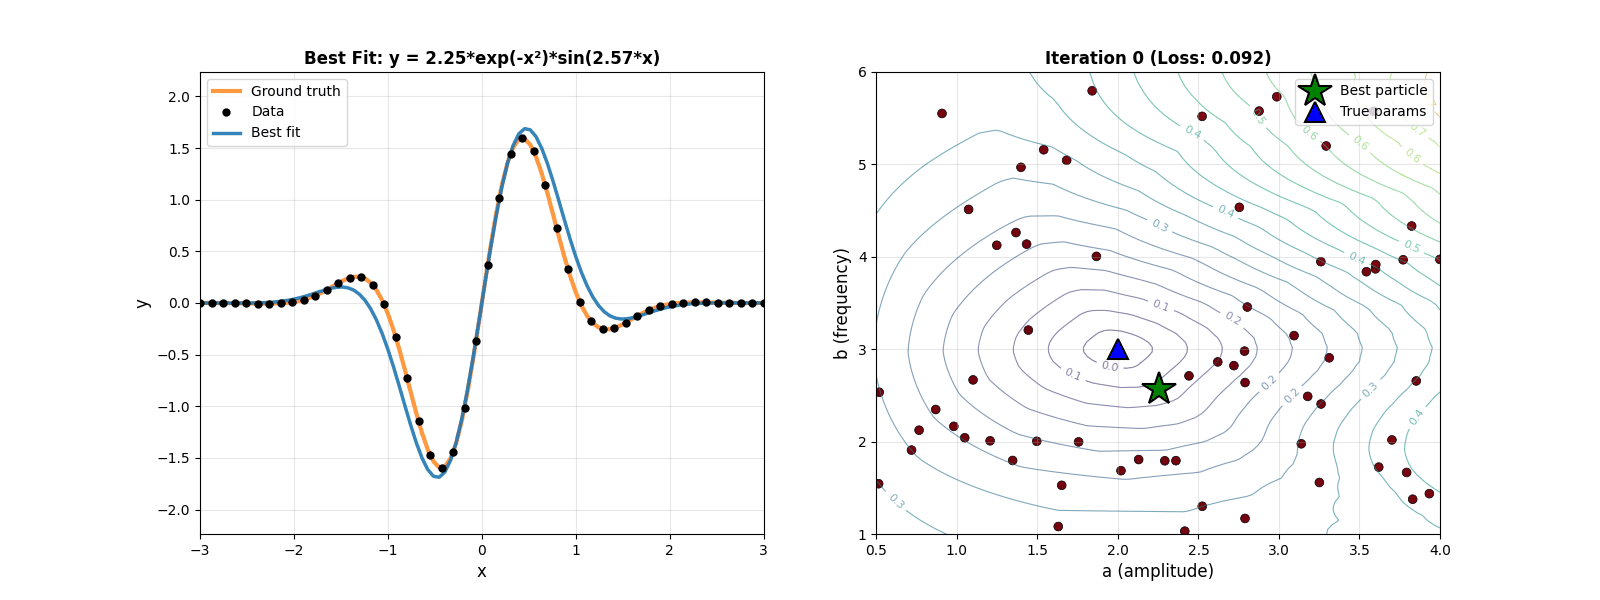

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image, display

# Compute loss landscape for visualization
a_grid = torch.linspace(0.5, 4.0, 100)
b_grid = torch.linspace(1.0, 6.0, 100)
A, B = torch.meshgrid(a_grid, b_grid, indexing='ij')

loss_landscape = torch.zeros_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        y_pred = A[i, j] * torch.exp(-x_data**2) * torch.sin(B[i, j] * x_data)
        loss_landscape[i, j] = (y_pred - y_data).abs().mean().item()

# Create side-by-side animation: fitting (left) and parameter space (right)
fig, (ax_fit, ax_param) = plt.subplots(1, 2, figsize=(16, 6))

# --- LEFT PLOT: Fitting evolution ---
x_plot = torch.linspace(-3, 3, 100)
y_true_plot = a_true * torch.exp(-x_plot**2) * torch.sin(b_true * x_plot)

ax_fit.plot(x_plot.numpy(), y_true_plot.numpy(), 'C1', linewidth=3, 
           label='Ground truth', alpha=0.8)
ax_fit.plot(x_data.numpy(), y_data.numpy(), 'ko', markersize=5, label='Data', zorder=10)
best_line, = ax_fit.plot([], [], 'C0', linewidth=2.5, label='Best fit', alpha=0.9)
ax_fit.set_xlabel('x', fontsize=12)
ax_fit.set_ylabel('y', fontsize=12)
ax_fit.set_xlim(-3, 3)
# Dynamic y-axis based on data range with some padding
y_min, y_max = y_data.min().item(), y_data.max().item()
y_range = y_max - y_min
ax_fit.set_ylim(y_min - 0.2 * y_range, y_max + 0.2 * y_range)
ax_fit.grid(True, alpha=0.3)
ax_fit.legend(loc='upper left', fontsize=10)
title_fit = ax_fit.set_title('', fontsize=12, fontweight='bold')

# --- RIGHT PLOT: Parameter space evolution ---
contour = ax_param.contour(A.numpy(), B.numpy(), loss_landscape.numpy(), 
                           levels=20, cmap='viridis', alpha=0.6, linewidths=0.8)
ax_param.clabel(contour, inline=True, fontsize=8, fmt='%.1f')
scatter = ax_param.scatter([], [], c=[], cmap='Reds_r', s=40, 
                          edgecolors='black', linewidth=0.5, vmin=0, vmax=10)
best_marker, = ax_param.plot([], [], 'g*', markersize=25, markeredgecolor='black', 
                            markeredgewidth=1.5, label='Best particle')
ax_param.plot([a_true], [b_true], 'b^', markersize=15, 
             markeredgecolor='black', markeredgewidth=1.5, label='True params')
ax_param.set_xlabel('a (amplitude)', fontsize=12)
ax_param.set_ylabel('b (frequency)', fontsize=12)
ax_param.set_xlim(0.5, 4.0)
ax_param.set_ylim(1.0, 6.0)
ax_param.legend(loc='upper right', fontsize=10)
ax_param.grid(True, alpha=0.3)
title_param = ax_param.set_title('', fontsize=12, fontweight='bold')

def animate(frame):
    state = model.history[frame]
    losses = state['losses']
    best_a = state['best_a']
    best_b = state['best_b']
    
    # Update left plot: best fit curve
    y_best = best_a * torch.exp(-x_plot**2) * torch.sin(best_b * x_plot)
    best_line.set_data(x_plot.numpy(), y_best.numpy())
    title_fit.set_text(f'Best Fit: y = {best_a:.2f}*exp(-x²)*sin({best_b:.2f}*x)')
    
    # Update right plot: population in parameter space
    pop = torch.stack([state['population_a'], state['population_b']], dim=1)
    scatter.set_offsets(pop.numpy())
    scatter.set_array(losses.numpy())
    best_marker.set_data([best_a], [best_b])
    title_param.set_text(f'Iteration {frame} (Loss: {state["best_loss"]:.3f})')
    
    return best_line, scatter, best_marker, title_fit, title_param

# Sample every 3rd frame for smoother animation
frame_indices = list(range(0, len(model.history), 3))
anim = FuncAnimation(fig, animate, frames=frame_indices, 
                    interval=200, blit=True, repeat=True)

# Save and display
output_path = os.path.join("outputs", 'pso_animation.gif')
os.makedirs(os.path.dirname(output_path), exist_ok=True)

print("Creating optimization animation...")
anim.save(output_path, writer=PillowWriter(fps=5))
plt.close(fig)

display(Image(output_path))